### Imports

In [1]:
import numpy as np
import pandas as pd

from functools import wraps
from time import time

import torch
from torch.optim import SGD, Adam
from torch import nn
import random, torch
from tqdm import tqdm
import math
from sklearn.model_selection import train_test_split, KFold

from nexis_models.nexis_model_robin import run_Nexis

import matplotlib.pyplot as plt
%matplotlib inline

### Helper Functions

In [2]:
def timing(f):    
    @wraps(f)    
    def wrap(*args, **kw):
        ts = time()
        result = f(*args, **kw)
        te = time()
        print('func:%r  took: %2.4f sec' % (f.__name__,  te-ts))
        return result
    return wrap

### Trainer

In [3]:
def create_chunks(complete_list, chunk_size=None, num_chunks=None):
    '''
    Cut a list into multiple chunks, each having chunk_size 
    (the last chunk might be less than chunk_size) or having a total of num_    
    '''
    chunks = []
    if num_chunks is None:
        num_chunks = math.ceil(len(complete_list) / chunk_size)
    elif chunk_size is None:
        chunk_size = math.ceil(len(complete_list) / num_chunks)
    for i in range(num_chunks):
        chunks.append(complete_list[i * chunk_size: (i + 1) * chunk_size])
    return chunks

class Trainer():
    def __init__(self, model, loss, optimizer_type, learning_rate, epoch, batch_size, input_transform=lambda x: x,device='cpu'):
        """ 
        The class for training the model
        model: nn.Module            
            A pytorch model        
        optimizer_type: 'adam' or 'sgd' of 'adam_l2'       
        learning_rate: float, For optimizer selected
        epoch: int
        batch_size: int
        input_transform: func, transforming input. Can do reshape here
        device: selects for cpu or cuda device.
        """        
        self.device = device
        self.model = model.to(self.device)
        self.loss = loss.to(self.device)
        if optimizer_type == "sgd":
            self.optimizer = SGD(model.parameters(), learning_rate,momentum=0.9)
        elif optimizer_type == "adam":
            self.optimizer = Adam(model.parameters(), learning_rate)
        elif optimizer_type == 'adam_l2':
            self.optimizer = Adam(model.parameters(), learning_rate, weight_decay=1e-5)
        
        self.epoch = epoch
        self.batch_size = batch_size
        self.input_transform = input_transform
        
    @timing
    def train(self, inputs, outputs, poutputs, val_inputs, val_outputs, val_poutputs, targ_prop, nex_prop, draw_curve=False,early_stop=False,l1=1e-5,l2=0,silent=False,foldnum=9999):
        """ 
        Train the model

        Inputs
        ------
        train self.model with specified arguments
        inputs: np.array, The shape of input_transform(input) should be (ndata,nfeatures).
        outputs: np.array shape (ndata,nregions) The true values.
        poutputs: np.array shape (ndata,nregions) The values from Nexis.
        val_nputs: np.array, The shape of input_transform(val_input) should be (ndata,nfeatures).
        val_outputs: np.array shape (ndata,nregions)
        val_poutputs: np.array shape (ndata,nregions)
        early_stop: bool
        l1: float, lambda for l1 norm 0 turns off
        l2: float, lambda for l2 norm 0 turns off
        silent: bool. Controls whether or not to print the train and val error during training
        foldnum: int, INTERNAL VARIABLE. Used for naming saved state dictionary. Default value of 9999

        Outputs
        -------
        The outputs are in a dictionary. Below are the keys.
        losses: list[nepoch], List of loss values for training data
        val_losses: list[nepoch], List of validation loss values for training data
        accuracies: list[epoch], List of accuracies for training data (Pearson's Correlation Coefficent)
        val_accuracies: list[epoch], List of training accuracies for training data (Pearson's Correlation Coefficent)
        """
        inputs = self.input_transform(torch.tensor(inputs, dtype=torch.float)).to(self.device)
        outputs = torch.tensor(outputs, dtype=torch.float).to(self.device)
        poutputs = torch.tensor(poutputs, dtype=torch.float).to(self.device)
        val_inputs = self.input_transform(torch.tensor(val_inputs, dtype=torch.float)).to(self.device)
        val_outputs = torch.tensor(val_outputs, dtype=torch.float).to(self.device)
        
        losses = []
        accuracies = []
        val_losses = []
        val_accuracies = []
        weights = self.model.state_dict()
        lowest_val_loss = np.inf
        
        for n_epoch in tqdm(range(self.epoch), leave=False):
            self.model.train()
            batch_indices = list(range(inputs.shape[0]))
            random.shuffle(batch_indices)
            batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
            epoch_loss = 0
            epoch_acc = 0 
            for batch in batch_indices:
                batch_importance = len(batch) / len(outputs)
                batch_input = inputs[batch]
                batch_output = outputs[batch]
                batch_poutput = poutputs[batch]
                batch_predictions = self.model(batch_input)
                
                loss = self.loss(batch_predictions, batch_output, batch_poutput, targ_prop, nex_prop)
                
                # l1 norm
                l1_lambda = l1
                l1_norm = sum(p.sum() for p in self.model.parameters())
                loss = loss + l1_lambda * l1_norm

                # l2 norm
                l2_lambda = l2
                l2_norm = sum(p.pow(2.0).sum() for p in self.model.parameters())
                loss = loss + l2_lambda * l2_norm

                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                epoch_loss += loss.detach().cpu().item() * batch_importance
                
                acc = np.corrcoef(batch_predictions.detach().numpy(), batch_output.detach().numpy())[0:len(batch),len(batch):].diagonal().mean()
                epoch_acc += acc.item() * batch_importance
                val_loss, val_acc = self.evaluate(val_inputs, val_outputs, val_poutputs, targ_prop=targ_prop, nex_prop=nex_prop, print_acc=False)

            if n_epoch % 100 == 99 and not silent:
                print("Epoch %d/%d - Loss: %.3f - Acc: %.3f" % (n_epoch + 1, self.epoch, epoch_loss, epoch_acc))
                print("              Val_loss: %.3f - Val_acc: %.3f" % (val_loss, val_acc))
                print("Epoch %d/%d - Loss: %.3f" % (n_epoch + 1, self.epoch, epoch_loss))
                print("              Val_loss: %.3f" % (val_loss))
            losses.append(epoch_loss)            
            accuracies.append(epoch_acc)
            val_losses.append(val_loss)
            val_accuracies.append(val_acc)
            if early_stop:
                if val_loss < lowest_val_loss:
                    lowest_val_loss = val_loss
                    weights = self.model.state_dict()
                    
        if draw_curve:
            plt.figure()
            plt.plot(np.arange(self.epoch) + 1,losses,label='Training loss')
            plt.plot(np.arange(self.epoch) + 1,val_losses,label='Validation loss')
            plt.plot(np.arange(self.epoch) + 1,accuracies,label='Accuracy')
            plt.plot(np.arange(self.epoch) + 1,val_accuracies,label='Validation accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend() 
        
        if early_stop:
            self.model.load_state_dict(weights)
        
        torch.save(self.model.state_dict(), './model_dictionaries/kfold_'+str(foldnum)+'.pt')
        
        return {"losses": losses, "val_losses": val_losses, "accuracies": accuracies, "val_accuracies": val_accuracies}
        
    def evaluate(self, inputs, outputs, poutputs, targ_prop, nex_prop, print_acc=True):
        '''
        Evaluate the model used in Trainer
        
        Inputs
        ------
        inputs: np.array(ndata,nfeatures)
        outputs: np.array(ndata,nregions) The target outputs
        poutputs: np.array(ndata,nregions) The physics dervied output, Nexis
        targ_prop: float. Weight for target MAE in loss (used internally in model_loss)
        nex_prop: float. Weight for Nexis MAE in loss (used internally in model_loss)
        print_acc: bool. Print the accuracy metric after evaluation.
        
        Returns
        -------
        losses: float. Value of loss for evaluation.
        acc: float. Value of accuracy for evaluation.
        '''
        self.model.eval()
        batch_indices = list(range(inputs.shape[0]))
        batch_indices = create_chunks(batch_indices, chunk_size=self.batch_size)
        acc = 0 
        losses = 0
        for batch in batch_indices: 
            batch_importance = len(batch) / len(outputs)
            batch_input = inputs[batch]
            batch_output = outputs[batch]
            batch_poutput = poutputs[batch]

            with torch.no_grad():
                batch_predictions = self.model(batch_input)
                loss = self.loss(batch_predictions, batch_output, batch_poutput, targ_prop=targ_prop, nex_prop=nex_prop)

            batch_acc = np.corrcoef(batch_predictions.detach().numpy(), batch_output.detach().numpy())[0:len(batch),len(batch):].diagonal().mean()
            losses += loss.detach().cpu().item() * batch_importance
            acc += batch_acc.item() * batch_importance

        if print_acc:
            print("Accuracy: %.3f" % acc)

        return losses, acc

### kFold

In [4]:
def Kfold(model_func,num_features,num_hidden,num_regions,model_loss,targ_prop,nex_prop,k,Xs,ys,zs,test_Xs,test_ys,test_zs,epochs,draw_curve=True,early_stop=False,batchsize=128, optimizer='adam',lr=1e-3,l1=1e-5,l2=0,silent=False):
    """ 
    Do Kfold cross validation with the specified arguments
    Inputs
    ------
    model_func: function. Constructor of the model.   
    num_features: int. Number of features for model, input size.
    num_hidden: int. Number of perceptrons in hidden layers.
    num_regions: int. Number of regions for predictions, output size. 
    model_loss: function. Constructor of the loss function. 
    targ_prop: float. Weight for target MAE in loss (used internally in model_loss)
    nex_prop: float. Weight for Nexis MAE in loss (used internally in model_loss)
    k: int. The number of fold    
    Xs: np.array, The shape of Xs.reshape(input_shape) should be (ndata,nfeatures)    
    ys: np.array, shape (ndata,nregions)    
    zs: np.array, shape (ndata,nregions)
    test_Xs: np.array, The shape of test_Xs.reshape(input_shape) should be (ndata,nfeatures)   
    test_ys: np.array, shape (ndata,nregions)    
    test_zs: np.array, shape (ndata,nregions)
    epoch: int
    draw_curve: bool   
    early_stop: bool
    batch_size: int      
    optimizer: 'sgd' or 'adam' or 'adam_l2'
    lr: float, learning_rate for optimizer
    l1: float, lambda for l1 norm 0 turns off
    l2: float, lambda for l2 norm 0 turns off
    silent: bool. Controls whether or not to print the train and val error during training 
    Returns
    -------
    vals: list[nfolds], np.array(ndata, nregions) a list of model predictions on the test data with the final model for that fold 
    """    
    # The total number of examples for training the network
    total_num=len(Xs)    
    # Built in K-fold function in Sci-Kit Learn
    kf=KFold(n_splits=k,shuffle=True)
    train_acc_all=[]
    test_acc_all=[]
    vals=[]
    fold=0

    for train_selector,val_selector in kf.split(range(total_num)):
        fold+=1
        print(f'Fold #{fold}')
        
        train_Xs=Xs[train_selector]
        val_Xs=Xs[val_selector]
        train_ys=ys[train_selector]
        val_ys=ys[val_selector]
        train_zs=zs[train_selector]
        val_zs=zs[val_selector]
        
        model=model_func(input_size=num_features, hidden_size=num_hidden, output_size=num_regions)
        loss=model_loss()
        if fold ==1:
            print(f"{model_func.__name__} parameters:", sum([len(item.flatten()) for item in model.parameters()]))
        
        device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
        trainer = Trainer(model, loss, optimizer, lr, epochs, batchsize, lambda x: x, device=device) # *** x.reshape(input_shape)
        log=trainer.train(train_Xs, train_ys, train_zs, val_Xs, val_ys, val_zs, targ_prop=targ_prop, nex_prop=nex_prop, early_stop=early_stop, l1=l1, l2=l2, silent=silent, foldnum=fold)
        
        if draw_curve:
            fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
            
            ax1.plot(log["losses"], label="losses")
            ax1.plot(log["val_losses"], label="validation_losses")
            ax1.set_title('MAE Loss')
            ax1.set_xlabel('Epochs')
            ax1.set_ylabel('Loss')
            ax1.legend()
            
            ax2.plot(log["accuracies"], label="accuracies")
            ax2.plot(log["val_accuracies"], label="validation_accuracies")
            ax2.set_title('Accuracy')
            ax2.set_xlabel('Epochs')
            ax2.set_ylabel('Pearson\'s Correlation Coefficient')
            ax2.legend()
            
            fig.suptitle(f'Fold #{fold}')

        # Report result for this fold
        if early_stop:
            report_idx= np.argmin(log["val_losses"])
        else:
            report_idx=-1
        
        test_Xs=torch.tensor(test_Xs,dtype=torch.float).to(device) # test_Xs.reshape(input_shape)
        test_ys=torch.tensor(test_ys,dtype=torch.float).to(device)
        test_zs=torch.tensor(test_zs,dtype=torch.float).to(device)
        
        test_acc=trainer.evaluate(test_Xs,test_ys,test_zs,targ_prop=targ_prop,nex_prop=nex_prop,print_acc=False)[1]
        train_acc_all.append(log["accuracies"][report_idx])
        test_acc_all.append(test_acc)

        # Perform evaluation directly instead of through trainer class
        model.eval()
        vals.append(model(test_Xs).detach().numpy())

        print("Train accuracy:",log["accuracies"][report_idx])
        print("Validation accuracy:",log["val_accuracies"][report_idx])
        print("Test accuracy:",test_acc)
    
    print()
    # print(test_acc_all)
    print("Final results:")
    print("Training accuracy:%f+-%f"%(np.average(train_acc_all),np.std(train_acc_all)))
    print("Testing accuracy:%f+-%f"%(np.average(test_acc_all),np.std(test_acc_all)))

    return vals

### Model and Loss

In [5]:
class PINNLoss(nn.Module):
    """
    Physics informed loss function model for ADNI Dataset MAE(NN, tau)+MAE(Nexis, tau)
    """
    def __init__(self):
        super(PINNLoss, self).__init__()
    
    def forward(self, predictions, targets, nexis, targ_prop, nex_prop):
        """
        predictions: np.array shape(ndata,nregions) Predicted NN values
        targets: np.array shape(ndata,nregions) True values provided
        nexis: np.array shape(ndata,nregions) Predicted nexis values
        """
        return targ_prop*torch.mean(abs(predictions - targets)) + nex_prop*torch.mean(abs(predictions - nexis))

In [6]:
class NN(nn.Module):
    """
    DNN model for ADNI Dataset
    """
    def __init__(self, input_size, hidden_size, output_size):
        """
        input_size: int (nfeatures)
        hidden_size: int
        output_size: int (nregions)
        """        
        super(NN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.layers = nn.Sequential(nn.Linear(self.input_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.hidden_size),
                                    nn.ReLU(),
                                    nn.Linear(self.hidden_size, self.output_size)
                                    )            
        
    def forward(self, x):
       return self.layers(x)    


### Read Data

In [7]:
# Read in normalized connectome
connectome = np.genfromtxt("./data/connectome_mean80_fibercount_normalized.csv", delimiter=",", missing_values="+")
connectome = connectome[1:, 1:]

# Read in patient data
data = np.genfromtxt("./data/Tau_with_Demographics_Normalized.csv", delimiter=",", missing_values="9999")
data = data[1:, 1:]
times = data[:, -2:-1] # extracts ml stage

# Read in generated seed data
seeds = np.genfromtxt("./data/fake_seed_data_forward_model.csv", delimiter=",", missing_values="9999")
seeds = seeds[1:, 1:]

# find index of first region in data
data_df = pd.read_csv("./data/Tau_with_Demographics_Normalized.csv").drop(columns=['Unnamed: 0'])
first_region_idx = list(data_df.columns).index('ctx-rh-bankssts')

# isolate true values for loss evaluation
true_tau = data[:,first_region_idx:first_region_idx+connectome.shape[0]]

### Generate Nexis Data

In [8]:
nexis_tau = np.zeros((data.shape[0],connectome.shape[0]))
for i in range(data.shape[0]):

    nexis = run_Nexis(C_=connectome,
                      U_=np.zeros((connectome.shape[0],1)),
                      init_vec_=seeds[:, first_region_idx:first_region_idx+connectome.shape[0]][i],
                      t_vec_=times[i],
                      w_dir_=0,
                      volcorrect_=0,
                      use_baseline_=0,
                      region_volumes_=[],
                      logistic_term_=0,
                      datadir_='')

    # Parameters derived from EBM data
    tau = nexis.simulate_nexis([0.2657846630222205,
                                0.490150501498850,
                                1.0,
                                0.5,
                                0.0,
                                0.07,
                                20.00056768387249])
    
    nexis_tau[i] = tau.T[0]

### Train/Test Split

In [9]:
# split from index where all in train or all in test (patients)
split_idx = 600

X_train = seeds[:split_idx,:]
y_train = true_tau[:split_idx,:]
z_train = nexis_tau[:split_idx,:]

X_test = seeds[split_idx:,:]
y_test = true_tau[split_idx:,:]
z_test = nexis_tau[split_idx:,:]

# X_train, X_test, y_train, y_test, z_train, z_test = train_test_split(seeds, true_tau, nexis_tau, test_size=0.33)

### Running

In [10]:
# Uses twice as many perceptrons per hidden layer as there are input features

num_features = X_train.shape[1]
num_hidden = 2*num_features
num_regions = connectome.shape[1]

Fold #1
NN parameters: 352130


func:'train'  took: 23.4856 sec
Train accuracy: 0.5284271602016487
Validation accuracy: 0.5326628987130607
Test accuracy: 0.5360116475791697
Fold #2


/tmp/ipykernel_124090/66844984.py:87: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_Xs=torch.tensor(test_Xs,dtype=torch.float).to(device) # test_Xs.reshape(input_shape)
/tmp/ipykernel_124090/66844984.py:88: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_ys=torch.tensor(test_ys,dtype=torch.float).to(device)
/tmp/ipykernel_124090/66844984.py:89: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_zs=torch.tensor(test_zs,dtype=torch.float).to(device)


func:'train'  took: 22.3857 sec
Train accuracy: 0.5252348150701072
Validation accuracy: 0.52465798195307
Test accuracy: 0.5317319349529446
Fold #3


func:'train'  took: 22.5766 sec
Train accuracy: 0.5154794125967141
Validation accuracy: 0.5110629690608237
Test accuracy: 0.5205650457176069

Final results:
Training accuracy:0.523047+-0.005508
Testing accuracy:0.529436+-0.006512


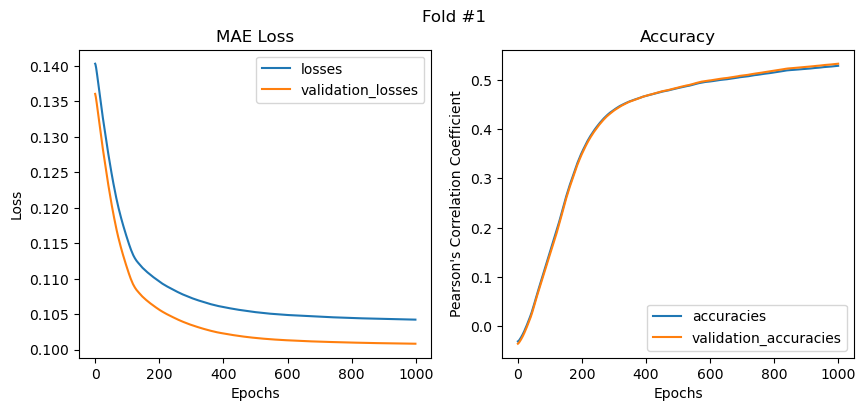

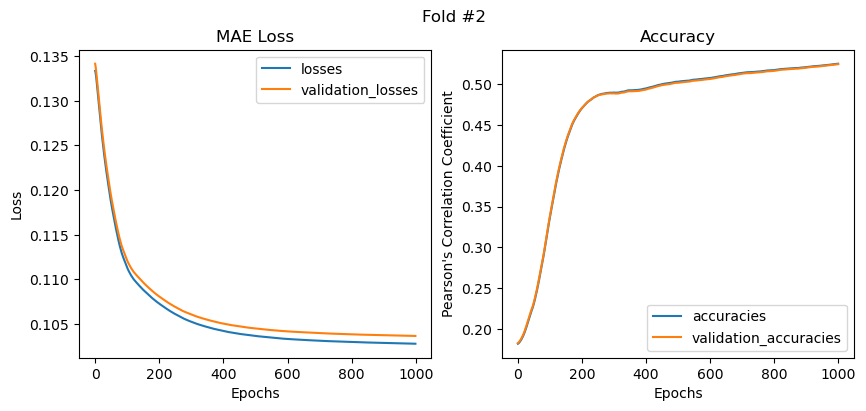

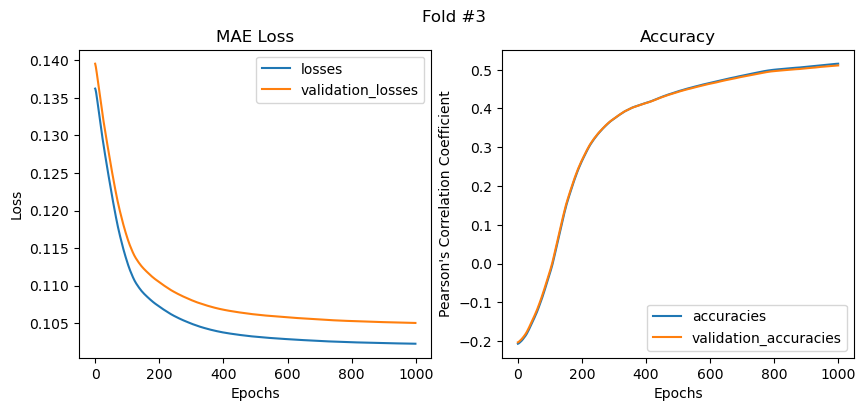

In [11]:
vals = Kfold(model_func=NN,
             num_features=num_features,
             num_hidden=num_hidden,
             num_regions=num_regions,
             model_loss=PINNLoss,
             targ_prop=0.5, 
             nex_prop=0.5,
             k=3,
             Xs=X_train,
             ys=y_train,
             zs=z_train,
             test_Xs=X_test,
             test_ys=y_test,
             test_zs=z_test,
             epochs=1000,
             draw_curve=True,
             early_stop=True,
             batchsize=128,
             optimizer='sgd',
             lr=1e-3,
             l1=0,
             l2=0,
             silent=True)

In [12]:
# Change best_fold to select desired model from fold
best_fold = 3

model = NN(num_features, num_hidden, num_regions)
model.load_state_dict(torch.load('./model_dictionaries/kfold_'+str(best_fold)+'.pt'))
model.eval()

NN(
  (layers): Sequential(
    (0): Linear(in_features=99, out_features=198, bias=True)
    (1): ReLU()
    (2): Linear(in_features=198, out_features=198, bias=True)
    (3): ReLU()
    (4): Linear(in_features=198, out_features=198, bias=True)
    (5): ReLU()
    (6): Linear(in_features=198, out_features=198, bias=True)
    (7): ReLU()
    (8): Linear(in_features=198, out_features=198, bias=True)
    (9): ReLU()
    (10): Linear(in_features=198, out_features=198, bias=True)
    (11): ReLU()
    (12): Linear(in_features=198, out_features=198, bias=True)
    (13): ReLU()
    (14): Linear(in_features=198, out_features=198, bias=True)
    (15): ReLU()
    (16): Linear(in_features=198, out_features=198, bias=True)
    (17): ReLU()
    (18): Linear(in_features=198, out_features=86, bias=True)
  )
)

### Run Model

In [ ]:
# Select patient data (ex. the first patient in X_train or all of X_test)
patient_data = X_test

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
tau = model(torch.tensor(patient_data, dtype=torch.float).to(device))
tau

### Average Pearson's Correlation Coeficient for Test Set

In [14]:
print("Coorelation (Target-Nexis):", np.corrcoef(y_test, z_test)[0:len(y_test), len(z_test):].diagonal().mean())
print("Correlation (Predicted-Target):", np.corrcoef(tau.detach().numpy(), y_test)[0:len(tau), len(y_test):].diagonal().mean())
print("Correlation (Predicted-Nexis):", np.corrcoef(tau.detach().numpy(), z_test)[0:len(tau), len(z_test):].diagonal().mean())

Coorelation (Target-Nexis): 0.014517721298270518
Correlation (Predicted-Target): 0.5205650487072969
Correlation (Predicted-Nexis): 0.5772592699946665


### Notes About Deltas

The variable `vals` returned by the function `kfold()` is a list that contains the model predictions for the test data for each fold. 

In [15]:
deltas = []
for val in vals:
    deltas.append(val - y_test)

The variable `deltas` is a list containing numpy arrays with the difference between the model predictions and the target tau values for each fold. Since some rows were dropped during data normalization, then it may be required to bring over row IDs during the data normalization process, separate, and store these IDs to be used later when remerging the data. Alternatively, the same data normalization process (regarding how rows are dropped) can be incorporated for all models and thus maintaining row IDs would become a non-issue since the data could be merged directly based off row index.

In [16]:
numfolds = 3
all_taus = []
all_deltas = []

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
for i in range(numfolds):
    model = NN(num_features, num_hidden, num_regions)
    model.load_state_dict(torch.load('./model_dictionaries/kfold_'+str(i+1)+'.pt'))
    model.eval()

    all_taus.append(model(torch.tensor(seeds, dtype=torch.float).to(device)).to(device).detach().numpy())
    all_deltas.append(all_taus[-1] - true_tau)

Here, the variable `all_taus` is a list of length nfolds that contains numpy arrays (ndata,nregions) containing the tau predictions for all patient data provided. Meanwhile, the variable `all_deltas` is a list of length nfolds that contains numpy arrays (ndata,nregions) containins the differences between the predicted tau values and the associated target value. As mentioned before, the IDs for each row will need to be tracked to ensure that these values are properly associated with the correct patient when the data is exported and used elsewhere.